In [1]:
import os
if not os.path.exists('GTSRB'):
    !pip install -U -q torch_snippets
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
    !unzip -qq GTSRB_Final_Training_Images.zip
    !unzip -qq GTSRB_Final_Test_Images.zip
    !wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
    !rm GTSRB_Final_Training_Images.zip GTSRB_Final_Test_Images.zip

     |████████████████████████████████| 49 kB 2.8 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
     |████████████████████████████████| 232 kB 29.5 MB/s 
     |████████████████████████████████| 58 kB 6.5 MB/s 
     |████████████████████████████████| 11.1 MB 71.2 MB/s 
     |████████████████████████████████| 948 kB 56.4 MB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
     |████████████████████████████████| 51 kB 8.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.
--2022-05-29 04:04:16--  https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.gi

In [2]:
!cat /content/GTSRB/Readme-Images.txt

**********************************************
The German Traffic Sign Recognition Benchmark
**********************************************

This archive contains the training set of the 
"German Traffic Sign Recognition Benchmark".

This training set is supposed be used for the online competition 
as part of the IJCNN 2011 competition. It is a subset of the final
training set that will be published after the online competition is
closed. 


**********************************************
Archive content
**********************************************
This archive contains the following structure:

There is one directory for each of the 43 classes (0000 - 00043).
Each directory contains the corresponding training images and one 
text file with annotations, eg. GT-00000.csv. 


**********************************************
Image format and naming
**********************************************
The images are PPM images (RGB color). Files are numbered in two parts:

   XXXXX_YYYYY.ppm

The

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

plt.rcParams['font.family'] = 'sans-serif'
warnings.filterwarnings('ignore')

In [4]:
sign_names = pd.read_csv("/content/signnames.csv")

In [5]:
sign_names.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [6]:
sign_names.shape

(43, 2)

In [7]:
f"There are {sign_names.ClassId.nunique()} diferrent classes in dataset"

'There are 43 diferrent classes in dataset'

In [8]:
class_id_2_name = dict(zip(sign_names['ClassId'].unique(),sign_names['SignName'].unique()))

In [9]:
from torch_snippets import parent,fname,Glob,read,logger,Report

In [10]:
all_files = Glob('GTSRB/Final_Training/Images/*/*.ppm')

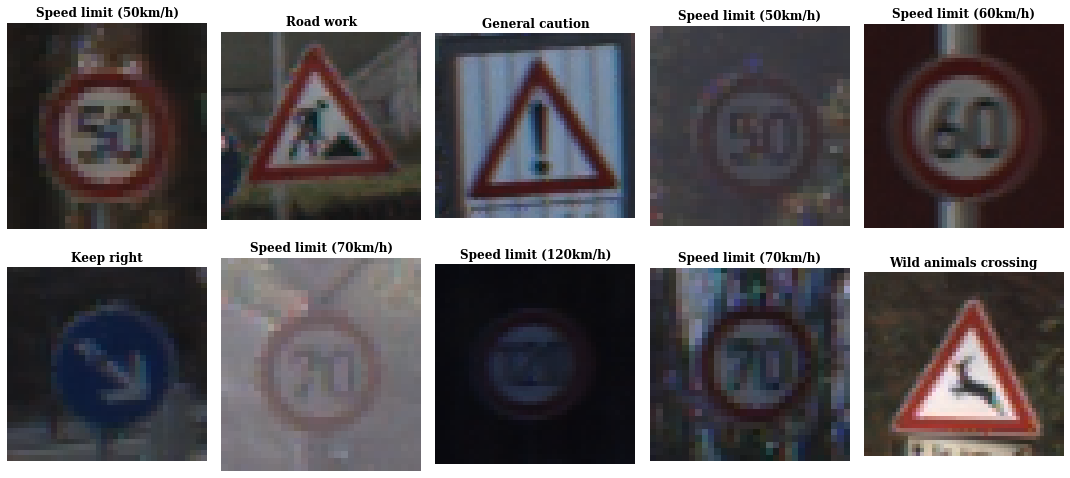

In [11]:
rand_ids = np.random.choice(range(len(all_files)),10)

_,ax=plt.subplots(2,5,figsize=(15,7))
axi  = ax.flatten()

for i,id_ in enumerate(rand_ids):
  fpath = all_files[id_]
  class_id = fname(parent(fpath))
  title = class_id_2_name[int(class_id)]
  image = read(fpath, 1)
  axi[i].imshow(image)
  axi[i].set_title(f"{title}",fontfamily='serif',fontweight='semibold')
  axi[i].axis('off')

plt.tight_layout()  
plt.show()

### Create pytorch dataset class

In [12]:
from tqdm import tqdm
import torch
from torch.utils.data import Dataset,DataLoader,random_split
from torchvision import transforms
import torch.nn as nn

In [13]:
class TrafficDataset(Dataset):
  def __init__(self,files,transform=None):
    self.files = files
    self.transform = transform
    logger.info(f'total images:{len(self.files):,}')

  def __len__(self):
    return len(self.files)
  
  def __getitem__(self,idx):
    fp = self.files[idx]
    class_id = fname(parent(fp))
    image = read(fp, 1)
    if self.transform:
      image = self.transform(image)
    else:
      image = torch.tensor(image/255).permute(2,0,1).float()
    class_id = torch.tensor([int(class_id)]).float()
    return image,int(class_id)

In [14]:
augmentation = transforms.Compose([
      transforms.ToPILImage(),
      transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
      transforms.RandomRotation(degrees=15),
      transforms.RandomHorizontalFlip(),
      # transforms.CenterCrop(size=32),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((32,32)),
      # transforms.CenterCrop(size=32),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [15]:
dm = TrafficDataset(all_files,transform)

2022-05-29 04:04:24.220 | INFO     | __main__:__init__:5 - total images:39,209


In [16]:
dm[0][0].size()

torch.Size([3, 32, 32])

In [17]:
train_files, valid_files = random_split(all_files,[35000,4209], generator=torch.Generator().manual_seed(42))

In [18]:
train_data = TrafficDataset(train_files, transform=augmentation)
valid_data = TrafficDataset(valid_files, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True,drop_last=True)
valid_dataloader = DataLoader(valid_data, batch_size=500, shuffle=False,drop_last=True)

2022-05-29 04:04:24.259 | INFO     | __main__:__init__:5 - total images:35,000
2022-05-29 04:04:24.263 | INFO     | __main__:__init__:5 - total images:4,209


In [19]:
next(iter(valid_dataloader))

[tensor([[[[-1.8782, -1.9124, -1.8953,  ..., -1.9124, -1.9124, -1.9467],
           [-1.8782, -1.8953, -1.8953,  ..., -1.9467, -1.9124, -1.9295],
           [-1.8782, -1.8782, -1.8953,  ..., -1.9638, -1.9295, -1.9295],
           ...,
           [-1.9467, -1.9295, -1.9295,  ..., -1.9124, -1.9295, -1.9295],
           [-1.9467, -1.9295, -1.9295,  ..., -1.9124, -1.9124, -1.9124],
           [-1.9295, -1.9295, -1.9295,  ..., -1.9124, -1.9124, -1.9295]],
 
          [[-1.8081, -1.8431, -1.8431,  ..., -1.8606, -1.8606, -1.8782],
           [-1.8081, -1.8256, -1.8256,  ..., -1.8782, -1.8606, -1.8606],
           [-1.8256, -1.8081, -1.8256,  ..., -1.8782, -1.8782, -1.8782],
           ...,
           [-1.8782, -1.8606, -1.8606,  ..., -1.8606, -1.8606, -1.8606],
           [-1.8782, -1.8606, -1.8606,  ..., -1.8606, -1.8606, -1.8431],
           [-1.8606, -1.8606, -1.8606,  ..., -1.8431, -1.8431, -1.8606]],
 
          [[-1.5256, -1.5779, -1.5779,  ..., -1.5953, -1.5953, -1.6127],
           [-

In [20]:
def get_layer_size(I,K,P,S):
  return int(np.floor(((I-K+2*P)/S)+1))

def get_layer_size_maxpool(I,K,S=None):
  if S is None:
    S = K
  return int(np.floor((I-K)/S)+1)

In [21]:
KERNEL =3
KERNEL_POOL =2

l1 = get_layer_size(32,KERNEL,0,1)
l10 = get_layer_size_maxpool(l1,KERNEL_POOL)


l2 = get_layer_size(l10,KERNEL,0,1)
l20 = get_layer_size_maxpool(l2,KERNEL_POOL)

l3 = get_layer_size(l20,KERNEL,0,1)
l30= get_layer_size_maxpool(l3 ,KERNEL_POOL)

l4 = get_layer_size(l30,KERNEL,0,1)
l40 = get_layer_size_maxpool(l4,KERNEL_POOL)

# l5 = get_layer_size(l40,KERNEL,0,1)
# l50 = get_layer_size_maxpool(l5,KERNEL_POOL)

# l6 = get_layer_size(l50,KERNEL,0,1)
# l60 = get_layer_size_maxpool(l6,KERNEL_POOL)

l30

2

In [22]:
class SignClassifier(nn.Module):
  def __init__(self,KERNEL_SIZE=3):
    super().__init__()
    self.convo_max1 = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=64,kernel_size=KERNEL_SIZE),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.convo_max2 = nn.Sequential(
        nn.Conv2d(in_channels=64,out_channels=64,kernel_size=KERNEL_SIZE),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.convo_max3 = nn.Sequential(
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=KERNEL_SIZE),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )

    self.fc1 = nn.Linear(128*2*2*1,43)

  def forward(self,x):
    x = self.convo_max1(x)
    x = self.convo_max2(x)
    x = self.convo_max3(x)
    # print(x.size())
    x = torch.flatten(x,1)
    # print(x.size())
    x = self.fc1(x)
    # return torch.softmax(x,dim=1)
    return x

In [23]:
model = SignClassifier()
model

SignClassifier(
  (convo_max1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convo_max2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convo_max3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=512, out_features=43, bias=True)
)

In [24]:
sample_image = next(iter(train_dataloader))[0][0]

In [25]:
model(sample_image.view(-1,3,32,32))

tensor([[-1.1357, -0.8457,  0.7758,  0.1858, -0.2546,  0.2974, -0.4334, -1.1835,
          1.1110, -0.6782,  0.2563, -1.0742, -0.1419, -1.4981, -0.9886,  0.1299,
          0.8829, -0.3958,  0.9057,  1.3558, -1.1898,  0.5374, -0.3290, -1.5891,
          0.8227, -1.0692,  0.7037, -0.4760,  0.7200,  0.4791, -0.2645,  2.3096,
         -1.3410, -1.1920, -0.1770,  0.0301, -1.4871,  0.4103, -0.7443,  1.0847,
         -0.6149,  0.0715, -0.1432]], grad_fn=<AddmmBackward0>)

In [26]:
from torchsummary import summary
summary(model, input_size=(3, 32, 32),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
              ReLU-2           [-1, 64, 30, 30]               0
       BatchNorm2d-3           [-1, 64, 30, 30]             128
         MaxPool2d-4           [-1, 64, 15, 15]               0
            Conv2d-5           [-1, 64, 13, 13]          36,928
              ReLU-6           [-1, 64, 13, 13]               0
       BatchNorm2d-7           [-1, 64, 13, 13]             128
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 4, 4]          73,856
             ReLU-10            [-1, 128, 4, 4]               0
      BatchNorm2d-11            [-1, 128, 4, 4]             256
        MaxPool2d-12            [-1, 128, 2, 2]               0
           Linear-13                   [-1, 43]          22,059
Total params: 135,147
Trainable params:

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [28]:
?nn.BCEWithLogitsLoss

In [29]:
def trainModel(epochs,lr):
  log = Report(epochs)

  net = SignClassifier().to(device)
  LossFun = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=net.parameters(),lr=lr)

  losses = torch.zeros(epochs)
  testAccuracy = torch.zeros(epochs)
  trainAccurscy = torch.zeros(epochs)

  N = len(train_dataloader)

  for i in tqdm(range(epochs)):
    net.train()
    batchLoss = []
    batchAccuracy = []
    for j,data in enumerate(train_dataloader):
      X,y = data[0],data[1]
      X = X.to(device)
      yHat = net(X)
      y = y.to(device)
      # print(yHat)
      loss = LossFun(yHat,y)

      accuracy = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
      batchAccuracy.append(accuracy.item())
      batchLoss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      log.record(pos=i+(j+1)/N,trn_loss=loss, trn_acc=accuracy, end='\r')#;break
    losses[i] = np.mean(batchLoss)
    trainAccurscy[i] = np.mean(batchAccuracy)

    net.eval()
    X,y = next(iter(valid_dataloader))
    X,y = X.to(device),y.to(device)

    # indices = torch.randperm(len(X))[:32]
    # X = X[indices].to(device)
    # y = y[indices].to(device)
    with torch.no_grad():
      # print("Validation started!!!")
      yHat = net(X)
      # yHat = torch.softmax(yHat)

    loss = LossFun(yHat,y)
    accuracy = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
    log.record(pos=i+(j+1)/N,val_loss=loss, val_acc=accuracy, end='\r')

    testAccuracy[i] = accuracy
  return net,losses,testAccuracy,trainAccurscy

In [30]:
len(valid_dataloader)

8

In [31]:
model,losses,testAccuracy,trainAccurscy = trainModel(5,lr=1e-3)

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1.000	trn_loss: 0.489	trn_acc: 90.625	(44.11s - 176.45s remaining)

 20%|██        | 1/5 [00:32<02:10, 32.67s/it]

EPOCH: 2.000	trn_loss: 0.315	trn_acc: 93.750	(75.55s - 113.32s remaining)

 40%|████      | 2/5 [01:04<01:35, 31.93s/it]

EPOCH: 3.000	trn_loss: 0.051	trn_acc: 96.875	(106.48s - 70.99s remaining)

 60%|██████    | 3/5 [01:35<01:02, 31.48s/it]

EPOCH: 4.000	trn_loss: 0.203	trn_acc: 90.625	(137.63s - 34.41s remaining)

 80%|████████  | 4/5 [02:06<00:31, 31.35s/it]

EPOCH: 5.000	trn_loss: 0.075	trn_acc: 100.000	(168.54s - 0.00s remaining)

100%|██████████| 5/5 [02:37<00:00, 31.41s/it]

EPOCH: 5.000	val_loss: 0.114	val_acc: 97.200	(168.79s - 0.00s remaining)

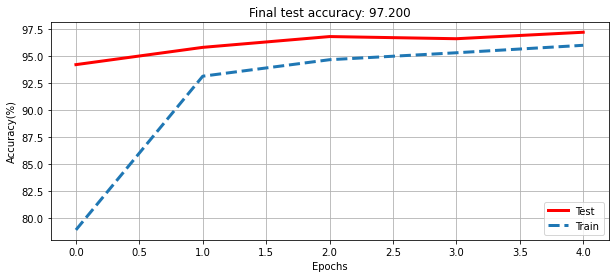

In [32]:
plt.figure(figsize=(10,4))
plt.title(f'Final test accuracy: {testAccuracy[-1]:.3f}')
plt.plot(testAccuracy,label='Test',linewidth=3,color='r')
plt.plot(trainAccurscy,label='Train',linestyle='--',linewidth=3)
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.grid(True)
plt.legend()
plt.show()

In [55]:
SignClassifierModel = model.cpu()

In [60]:
def get_preds(img):
  return SignClassifierModel(img.view(-1,3,32,32))